![logo](./img/logo_desafio.png)

# Desafio Natural Language Processing with Disaster Tweets

O [desafio](https://www.kaggle.com/c/nlp-getting-started) proposto consiste em um problema de classificação de texto. Mais especificamente, é tratada a classificação de tweets, os quais podem ser relacionados a desastres ou não. Para isso, utilizaremos ferramentas de Processamento de Linguagem Natural (NLP), bem como de Aprendizado de Máquina. 

Nesta solução, trataremos de

- Tokenização para Tweets com o "Tweet Tokenizer"
- Vetorização de palavras com o "Word Vectors"
- SVC e Regressão logística como classificadores

Ainda explicitaremos futuras melhorias ao final deste documento.


In [1]:
# Importacao de bibliotecas

import pandas as pd
import numpy as np
import zipfile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from tqdm import tqdm

In [2]:
# Carregamento dos dados de treino e teste

zf = zipfile.ZipFile('./data/nlp-getting-started.zip')
train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


A coluna 'keyword' tem potencial, ja que no treino e no teste tem poucos dados faltantes. No entanto, começaremos nossa análise por soluções focadas no conteúdo dos documentos.

## Tokenizador comum

Tokenizadores são ferramentas que nos auxiliam a transformar frases e documentos em conjuntos de palavras separadas. Por exemplo, a frase `'Three people died from the heat wave so far'`, presente na base de treino, é transformada em uma lista onde cada palavra é um token. O resultado é 

```['Three', 'people', 'died', 'from', 'the', 'heat', 'wave', 'so', 'far']```

In [7]:
stop_words_nltk = list(stopwords.words('english'))
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(train['text'].values)

In [8]:
csr_matrix(count_train).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
# Pegando uma frase de exemplo a ser tokenizada

train['text'].values[10]

'Three people died from the heat wave so far'

In [10]:
# Checando a tokenizacao da frase do indice 10

word_tokenize(train['text'][10])

['Three', 'people', 'died', 'from', 'the', 'heat', 'wave', 'so', 'far']

## Tweet tokenizer

O tokenizador anteriormente citado foi feito pensando em textos comuns. No entanto, sabemos que os tweets tem características próprias, como o uso de emojis, hashtags e diversas abreviações. 

Tendo isso em mente, optamos por testar o Tweet Tokenizer, um tokenizador na biblioteca NLTK otimizado para análise de textos contidos no Twitter.

In [11]:
from nltk.tokenize import TweetTokenizer

def tweet_tokenize_column(df, column):
    """     
        This function gets the Dataframe and the name of a column (String) containing texts (Strings) and returns
        a list of lists containing the tokenized text. It also turns every token to it's lower form and excludes
        stopwords.
        
        Essa funcao recebe o Dataframe e o nome de uma coluna (String) contendo textos (Strings), e retorna uma lista
        de listas contendo o texto tokenizado. A funcao tambem transforma todas as letras maiusculas em minusculas e 
        exclui stopwords.
        
        Input: Pandas DataFrame, String
        Return: Nested List
    """
    
    tweet_tokenizer = TweetTokenizer()
    
    # List of sentences / Lista de sentencas
    list_sent = [tweet_tokenizer.tokenize(sent) for sent in df[column].values]
    
    # List of sentences excluding stopword tokens / Lista de sentencas excluindo stopwords
    list_sent_no_stop = [[token.lower() 
                           for token in sent 
                           if token not in stopwords.words('english')] 
                           for sent in list_sent]
    
    return list_sent_no_stop

In [12]:
# Utilizando a funcao nas colunas de texto do treino e do teste

tokenized_sent_train = tweet_tokenize_column(train,'text')
tokenized_sent_test = tweet_tokenize_column(test,'text')

Conseguimos perceber a diferença dos tokenizadores. Nesse, conseguimos observar que a tokenização de palavras com hashtags foi melhorada.

In [13]:
tokenized_sent_train[:2]

[['our', 'deeds', 'reason', '#earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]

In [14]:
tokenized_sent_test[:2]

[['just', 'happened', 'terrible', 'car', 'crash'],
 ['heard',
  '#earthquake',
  'different',
  'cities',
  ',',
  'stay',
  'safe',
  'everyone',
  '.']]

Criaremos uma lista de listas contendo todos os tweets tokenizados, tanto do treino quanto do teste. Essa é uma forma de garantirmos uma análise unificada pelo TF-IDF, que será explicado posteriormente.

In [15]:
tokenized_sent_all = tokenized_sent_train + tokenized_sent_test

## TF-IDF

O TF-IDF (Term Frequency - Inverse Document Frequency) é uma estatística numérica que nos dá a importância de uma dada palavra em um conjunto de documentos (corpus linguístico). De maneira intuitiva, uma palavra (token) tem um alto score do TF-IDF se

- Tem um grande número de ocorrências em um documento
e
- Tem pouca ocorrência em diversos documentos

Esse "número" é consequência do produto do "TF" com o "IDF", esses calculados da seguinte forma


\begin{align}
    \operatorname{tf}(t, d)&=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}}\\\\
    \operatorname{idf}(t, D)&=\log \frac{N}{|\{d \in D: t \in d\}|}\\\\
    \operatorname{tfidf}(t, d, D)&=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
\end{align}

Todos os termos podem ser vistos com mais detalhes [neste link](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).



Vamos então aplicar o TF-IDF nos nossos datasets.

In [16]:
# Funcao auxiliar para bypass do tokenizador, uma vez que este passo ja foi feito.
def identity_tokenizer(text):
    return text

tfidf_all = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    
tfidf_all_fit = tfidf_all.fit_transform(tokenized_sent_all)

tfidf_all.get_feature_names()[1000:1002]


C:\Users\Rafael\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['#hail', '#haildamage']

Note que, pelo TF-IDF ter sido feito em todos os documentos tanto do treino quanto do teste, calculamos os scores tratando essa lista agregada como um novo corpus. Isso é positivo, já que teremos esse score calculado baseado em mais informações. 

In [17]:
# Criando o Dataframe de scores do tfidf unificado. Em suas 'n' primeiras linhas ha informacoes a respeito dos 
# documentos do treino e nas 'm' linhas seguintes, do teste, onde 'n' e o numero de documentos na base de treino, e 
# 'm' o numero de documentos dna base de teste.

tfidf_all_df = pd.DataFrame(tfidf_all_fit.toarray(), columns=tfidf_all.get_feature_names())

In [18]:
tfidf_all_df.head()

,!,#,##book,##fukushima,##youtube,#0215,#034,#039,#05,#0518,...,ûó,ûócategorically,ûóher,ûókaiserjaegers,ûókill,ûókody,ûónegligence,ûótech,ûówe,ûówere
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Separando os Dataframes de treino e teste

tfidf_train_df = tfidf_all_df[:len(train)]

tfidf_test_df = tfidf_all_df[len(train):]


In [20]:
# Incluindo a coluna de target no dataset de treino com o TF-IDF

tfidf_train_df["target_column"] = train['target']

<ipython-input-20-467081f4bd96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_train_df["target_column"] = train['target']


## Classificação

### Regressão Logística

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

X = tfidf_train_df.drop("target_column", axis=1)
y = tfidf_train_df["target_column"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

clf = LogisticRegression(random_state=16)

scores_logistic = cross_val_score(clf, X, y, cv=5)

In [22]:
scores_logistic.mean()

0.7047231974377979

In [23]:
from sklearn.metrics import accuracy_score

clf.fit(X,y)

y_pred = clf.predict(X)

print('Training accuracy is {}'.format(accuracy_score(y, y_pred)))

Training accuracy is 0.8903191908577434


Reparamos uma discrepância consideravel entre os scores de cross validation e do accuracy score. Observamos que isso pode ter a ver com o overfit, quando treinamos no dataset de treino inteiro, e do underfit quando separamos os datasets de treino e teste de maneira a treinar com um número muito menor de dados.

A submissão para o Kaggle nos deu um score público de 78,547%

In [24]:
# Submissao 0.78547

sample_submission = pd.read_csv(zf.open('sample_submission.csv'))

y_sub = clf.predict(tfidf_test_df)

In [25]:
sub = sample_submission.copy()
sub['target'] = y_sub
sub.set_index('id',inplace=True)

In [26]:
sub.head()

,target
id,
0,1
2,0
3,1
9,0
11,1


In [27]:
sub.to_csv("./submissions/sub_01.csv")

# Selecao de atributos

Como uma maneira de tentar diminuir o overfit e melhorar o desempenho da nossa classificação, optamos por usar os score s de $\chi^{2}$ e Informação Mútua a fim de selecionar as variáveis mais "importantes" para o nosso modelo, reduzindo também a dimensionalidade do problema. 

In [28]:
from sklearn.feature_selection import mutual_info_classif, chi2

# mi = mutual_info_classif(tfidf_train_df_int.drop("target_column", axis=1), tfidf_train_df_int["target_column"])
# mi = pd.Series(mi)
# mi.index = intersect_columns
# mi.sort_values(ascending=False, inplace=True) 

chi = chi2(X,y)
chi = pd.Series(chi[0])
chi.index = X.columns
chi.sort_values(ascending=False, inplace=True)    


In [29]:
chi[:5]

?             37.196852
california    29.250636
suicide       24.139547
:             24.103232
killed        23.600085
dtype: float64

In [30]:
chi.to_csv("./data/chi.csv")

Abaixo temos como código comentado alguns plots contendo informações sobre o número de variáveis selecionadas comparadas à variância da validação cruzada e ao score. Com essas informações temos uma melhor noção da influência positiva ou negativa da seleção de variáveis no modelo.

In [31]:
# atts = np.linspace(100,10000,100)
# list_scores = []
# list_var = []

# for att in tqdm(atts):
    
#     list_scores.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).mean())
#     list_var.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).var())

In [32]:
# int_atts = [int(att) for att in atts]

# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [33]:
# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_var, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [34]:
# atts = np.linspace(100,10000,100)
# list_scores_over = []

# for att in tqdm(atts):
#     clf.fit(X[chi[:int(att)].index],y)
#     y_pred = clf.predict(X[chi[:int(att)].index])
#     acc = accuracy_score(y, y_pred)
    
#     list_scores_over.append(acc)

In [35]:
# int_atts = [int(att) for att in atts]

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores_over, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [36]:
atts = np.linspace(100,10000,100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)



In [37]:
# list_scores_tts = []

# for att in tqdm(atts):
#     clf.fit(X_train[chi[:int(att)].index],y_train)
#     y_pred = clf.predict(X_test[chi[:int(att)].index])
#     acc = accuracy_score(y_test , y_pred)
    
#     list_scores_tts.append(acc)

In [38]:
# int_atts = [int(att) for att in atts]

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores_tts, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [39]:
# int_atts = [int(att) for att in atts]
# int_atts[np.array(list_scores_atts).argmax()]

In [40]:
clf.fit(X_train[chi[:3800].index],y_train)

y_pred = clf.predict(X_test[chi[:3800].index])

acc = accuracy_score(y_test , y_pred)

In [41]:
y_sub_chi = clf.predict(tfidf_test_df[chi[:3800].index])

In [42]:
sub_chi = sample_submission.copy()

sub_chi['target'] = y_sub_chi

sub_chi.set_index('id',inplace=True)

In [43]:
# Submissao selecionando as variaveis com o score de Chi^2

sub_chi.to_csv("./submissions/sub_chi.csv")

### Suppor Vector Classifier (SVC)

In [44]:
from sklearn.svm import SVC

clf_svc = SVC()
clf_svc.fit(X_train[chi[:3800].index],y_train)
y_pred = clf_svc.predict(X_test[chi[:3800].index])
acc = accuracy_score(y_test , y_pred)

print('Training accuracy is {}'.format(acc))

Training accuracy is 0.8214051214707814


In [45]:
clf_svc.fit(tfidf_train_df[chi[:3800].index],y)

SVC()

In [46]:
y_sub_svc = clf_svc.predict(tfidf_test_df[chi[:3800].index])

In [47]:
sub_svc = sample_submission.copy()
sub_svc['target'] = y_sub_svc
sub_svc.set_index('id',inplace=True)

sub_svc.to_csv("./submissions/sub_svc_overfit.csv")

In [48]:
# atts = [1000,3000,5000]
# list_scores_svc = []

# for att in tqdm(atts):
#     clf_svc.fit(X_train[chi[:int(att)].index],y_train)
#     y_pred = clf_svc.predict(X_test[chi[:int(att)].index])
#     acc = accuracy_score(y_test , y_pred)
    
#     list_scores_svc.append(acc)

# Word Vectors

Tendo em mão a solução por meio da tokenização com o TF-IDF, vamos agora partir para outro tipo de abstração, a de Vetores de Palavras. Essa abstração nos permite mapear as palavras como vetores multidimensionais, indicando o mapeamento dessa palavra não só em termos de "quantidade" como o TF-IDF, mas também levando o contexto em consideração.

Para exemplificar, a imagem abaixo representa as duas coordenadas mais importante de uma série de vetores de dimensão 300 (que representam palavras em um dado contexto).

<img src="./img/word_vectors_map.png" alt="Vetor de Palavras" width="600"/>



In [49]:
import spacy 

nlp = spacy.load('en_core_web_lg')

with nlp.disable_pipes():
    train_vecs = pd.DataFrame(np.array([nlp(text).vector for text in train.text])) # doc vectors for training set
    test_vecs = pd.DataFrame(np.array([nlp(text).vector for text in test.text])) # doc vectors for testing set

In [50]:
mi = mutual_info_classif(train_vecs,train.target)
mi = pd.Series(mi)
mi.index = train_vecs.columns
mi.sort_values(ascending=False, inplace=True)    

In [51]:
X_word_vec_train, X_word_vec_test, y_word_vec_train, y_word_vec_test = train_test_split(train_vecs, train.target.values, test_size=0.33, random_state=16)

In [52]:
svc = SVC()

atts = np.linspace(1, 299, 299)
list_scores_svc = []

for att in tqdm(atts):
    svc.fit(X_word_vec_train[mi[:int(att)].index].values, y_word_vec_train)
    y_pred = svc.predict(X_word_vec_test[mi[:int(att)].index].values)
    acc = accuracy_score(y_word_vec_test , y_pred)
    
    list_scores_svc.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [12:12<00:00,  2.45s/it]


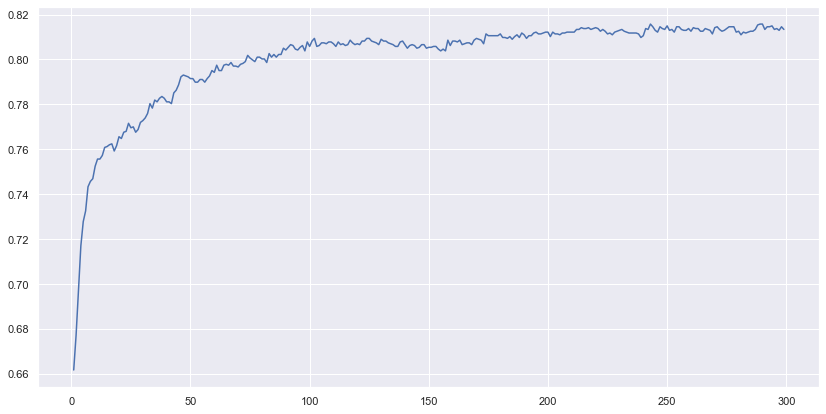

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

int_atts = [int(att) for att in atts]

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores_svc, x=atts)
plt.show()

In [54]:
svc.fit(train_vecs.values, train.target)
y_pred = svc.predict(test_vecs.values)

sub_svc = sample_submission.copy()
sub_svc['target'] = y_pred
sub_svc.set_index('id',inplace=True)

sub_svc.to_csv("./submissions/sub_svc_word_vec.csv")

## To-Do

- Testar outros modelos ( NaiveBayes, RidgeClassifier, ...)
- Usar o GridSearch para otimizacao dos hiperparametros
